In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import utils

In [3]:
# Config

figsize = (9, 3)

In [4]:
data_path = "./data"
data = utils.load_data(data_path)
data.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD001,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,train_FD001,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,train_FD001,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,train_FD001,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,train_FD001,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [5]:
# Last column is the RUL (Label)
dt_in = list(data.columns[3:-1])
data[dt_in].describe()

,p1,p2,p3,s1,s2,s3,s4,s5,s6,s7,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,...,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000
mean,17.211973,0.410004,95.724344,485.840890,597.361022,1467.035653,1260.956434,9.894999,14.424935,359.729968,...,338.789821,2349.645243,8088.950972,9.054747,0.025185,360.698801,2273.754039,98.389146,25.942709,15.565700
std,16.527988,0.367938,12.359044,30.420388,42.478516,118.175261,136.300073,4.265554,6.443922,174.133835,...,164.193480,111.167242,80.623257,0.751581,0.004997,31.021430,142.513114,4.656270,11.691422,7.015067
min,-0.008700,-0.000600,60.000000,445.000000,535.480000,1242.670000,1023.770000,3.910000,5.670000,136.170000,...,128.310000,2027.570000,7845.780000,8.156300,0.020000,302.000000,1915.000000,84.930000,10.160000,6.010500
25%,0.001300,0.000200,100.000000,449.440000,549.960000,1357.360000,1126.830000,5.480000,8.000000,175.710000,...,164.790000,2387.970000,8070.530000,8.439250,0.020000,332.000000,2212.000000,100.000000,14.330000,8.601300
50%,19.998100,0.620000,100.000000,489.050000,605.930000,1492.810000,1271.740000,9.350000,13.660000,341.690000,...,321.690000,2388.070000,8118.590000,9.030100,0.030000,367.000000,2319.000000,100.000000,24.920000,14.953500
75%,35.001500,0.840000,100.000000,518.670000,642.340000,1586.590000,1402.200000,14.620000,21.610000,553.290000,...,521.340000,2388.160000,8139.410000,9.344200,0.030000,392.000000,2388.000000,100.000000,38.820000,23.294600
max,42.008000,0.842000,100.000000,518.670000,645.110000,1616.910000,1441.490000,14.620000,21.610000,570.810000,...,537.490000,2390.490000,8293.720000,11.066900,0.030000,400.000000,2388.000000,100.000000,39.890000,23.950500


In [6]:
# Check for null-values
data[dt_in].isnull().any().any()

# No null values

False

In [7]:
# Standardize all the daa-columns

data_sv = data.copy()
data_sv[dt_in] = (data_sv[dt_in] - data_sv[dt_in].mean()) / data_sv[dt_in].std()
data_sv.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD001,1,1,-1.041426,-1.115415,0.345954,1.079181,1.046623,1.037987,1.024530,...,0.345198,0.616063,-0.845214,0.963586,1.009019,0.801652,0.345954,1.121959,1.119490,191
1,train_FD001,1,2,-1.041268,-1.115143,0.345954,1.079181,1.054391,1.055926,1.043166,...,0.345648,0.527627,-0.828849,0.963586,1.009019,0.801652,0.345954,1.116827,1.120146,190
2,train_FD001,1,3,-1.041644,-1.113512,0.345954,1.079181,1.059100,1.023517,1.050943,...,0.345288,0.549209,-0.847476,0.963586,0.944547,0.801652,0.345954,1.112550,1.108828,189
3,train_FD001,1,4,-1.041341,-1.114327,0.345954,1.079181,1.059100,0.979514,1.033848,...,0.345738,0.556651,-0.913470,0.963586,1.009019,0.801652,0.345954,1.106563,1.113061,188
4,train_FD001,1,5,-1.041498,-1.114871,0.345954,1.079181,1.059570,0.980022,1.065763,...,0.345378,0.556279,-0.832042,0.963586,1.041254,0.801652,0.345954,1.108273,1.117409,187


In [8]:
data_sv_dict = utils.split_by_field(data_sv, field='src')
print('{{{}}}'.format(', '.join(f'{k}: ...' for k in data_sv_dict.keys())))

{train_FD001: ..., train_FD002: ..., train_FD003: ..., train_FD004: ...}


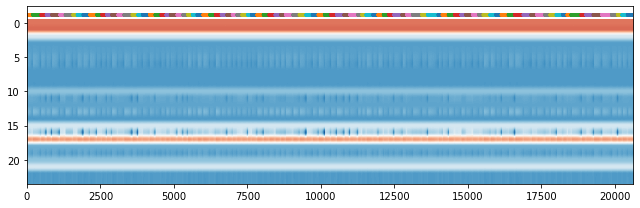

In [9]:
tmp = data_sv_dict['train_FD001']
utils.plot_dataframe(tmp[dt_in], labels=tmp['machine'], figsize=figsize)

In [ ]:
def test_env(env, episodes):
    for episode in range(1, episodes+1):
        state = env.reset()
        done = False
        score = 0
        
        while not done:
            action = env.action_space.sample()
            n_state, reward, done, info = env.step(action)
            score += reward
        print('Episode:{} Score:{}'.format(episode, score))
            
    